In [120]:
import os
import simba as si
from scipy import sparse
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mc
import seaborn as sns


si.__version__

'1.2'

In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

# make plots prettier
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
workdir = '/mnt/d/JorritvU/SIMBA/tests/0205-test/'
si.settings.set_workdir(workdir)

Saving results in: /mnt/d/JorritvU/SIMBA/tests/0205-test/


In [62]:
adata_s143 = si.read_h5ad('/mnt/d/JorritvU/Tripolar/scRNA-seq/s143/old/SNV/s143.germline.h5ad')

adata_s145 = si.read_h5ad('/mnt/d/JorritvU/Tripolar/scRNA-seq/s145/old/SNV/s145.germline.h5ad')

adata_chi006 = si.read_h5ad('/mnt/d/JorritvU/Tripolar/scDNA-seq/CHI-006/processed/SNV/CHI-006.germline_v2.h5ad')

adata_chi007 = si.read_h5ad('/mnt/d/JorritvU/Tripolar/scDNA-seq/CHI-007/processed/SNV/CHI-007.germline_v2.h5ad')

In [63]:
# Convert dense to sparse matrix
adata_s143.X = adata_s143.X + 1
adata_s143.X = sparse.csr_matrix(adata_s143.X)
adata_s143.X.A

array([[1, 1, 1, ..., 1, 2, 1],
       [1, 1, 1, ..., 1, 2, 1],
       [1, 1, 1, ..., 1, 2, 1],
       ...,
       [1, 1, 1, ..., 1, 2, 1],
       [1, 1, 1, ..., 1, 2, 1],
       [1, 1, 1, ..., 1, 2, 1]])

In [64]:
# Convert dense to sparse matrix
adata_s145.X = adata_s145.X + 1
adata_s145.X = sparse.csr_matrix(adata_s145.X)
adata_s145.X.A

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [65]:
# DNA samples are already sparse matrices.
adata_chi006.X.A

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [9]:
adata_chi007.X

<384x1530854 sparse matrix of type '<class 'numpy.int64'>'
	with 421208950 stored elements in Compressed Sparse Row format>

Now we filter on Allele Frequency (AF). <br/>
For now arbitrary number (0.1). 

In [69]:
adata_s143.var['pass'] = adata_s143.var['AF'] > 0.1

In [70]:
adata_s145.var['pass'] = adata_s145.var['AF'] > 0.1

In [71]:
adata_chi006.var['pass'] = adata_chi006.var['AF'] > 0.1

In [72]:
adata_chi007.var['pass'] = adata_chi007.var['AF'] > 0.1

## Merge the RNA runs into 1, and merge the DNA runs into 1

In [73]:
import anndata as ad

def merge_datasets(adata1, adata2):
    common_vars = list(set(adata1.var_names).intersection(set(adata2.var_names)))
    print(f"Number of intersecting SNVs: {len(common_vars)}")
    adata1 = adata1[:, common_vars]
    adata2 = adata2[:, common_vars]
    adata = ad.concat([adata1, adata2], merge='first', join='inner')
    return adata

In [74]:
adata_dna = merge_datasets(adata_chi006, adata_chi007)  
print(adata_dna)
adata_rna = merge_datasets(adata_s143, adata_s145)  
print(adata_rna)


Number of intersecting SNVs: 1211366
AnnData object with n_obs × n_vars = 768 × 1211366
    obs: 'Phenotype', 'Batch'
    var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass'
Number of intersecting SNVs: 18021
AnnData object with n_obs × n_vars = 454 × 18021
    obs: 'Phenotype', 'Batch'
    var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass'


# DNA and RNA

Filter the datasets on NAs, filter out AF > 0.05 (above we set the threshold to 0.1, so the one here does nothing).

Intersect the common vars (i.e. the common SNVs). 

This results in *5933* SNVs in each dataset.

In [75]:
"""
Filter the NaN samples and based on AF > 0.05.
If other sample types should be excluded, change code here.
"""

data = {'rna': adata_rna, 'dna': adata_dna}

for k in ['rna', 'dna']:
    data[f"{k}_filtered"] = data[k][~data[k].obs_names.str.contains('nan', na=False), data[k].var['AF'] > 0.05].copy()
    print(f"{k}_filtered: {data[f'{k}_filtered'].shape}")


filtered_datasets = [d for d in data.keys() if 'filtered' in d]
common_vars = set(data[filtered_datasets[1]].var_names).intersection(set(data[filtered_datasets[0]].var_names))

filtered_datasets = [d for d in data.keys() if 'filtered' in d]
# Filtered datasets 1 = DNA
for key in filtered_datasets:
    data[key] = data[key][:, list(common_vars)]

data

rna_filtered: (454, 14942)
dna_filtered: (731, 1177146)


{'rna': AnnData object with n_obs × n_vars = 454 × 18021
     obs: 'Phenotype', 'Batch'
     var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass',
 'dna': AnnData object with n_obs × n_vars = 768 × 1211366
     obs: 'Phenotype', 'Batch'
     var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass',
 'rna_filtered': View of AnnData object with n_obs × n_vars = 454 × 5933
     obs: 'Phenotype', 'Batch'
     var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass',
 'dna_filtered': View of AnnData object with n_obs × n_vars = 731 × 5933
     obs: 'Phenotype', 'Batch'
     var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass'}

## Add proportions to metadata

Here we add the proportions of each variant across the cells and across the SNVs.

Resulting in 3 lists in the variable metadata, and 3 lists in the observable metadata.

Proportions are calculated as the sum of the variant divided by the total count.

In [79]:
# Access the .X attribute where your SNV data is stored
# Convert it to a dense matrix if it's stored as a sparse matrix
for key in filtered_datasets:
    adata = data[key].copy()
    X_dense = data[key].X.toarray()
    
    # Count occurrences of each variant type (1, 2, 3) per cell
    variant_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=4)[1:], axis=1, arr=X_dense)
    
    # Calculate proportions
    variant_proportions = variant_counts / variant_counts.sum(axis=1, keepdims=True)
    
    # Add proportions back to adata as layers or as part of obs (depending on your preference)
    # Add variant proportions as separate columns in adata.obs
    data[key].obs['variant_1_proportion_0/0'] = variant_proportions[:, 0]
    data[key].obs['variant_2_proportion_0/1'] = variant_proportions[:, 1]
    data[key].obs['variant_3_proportion_1/1'] = variant_proportions[:, 2]


    snv_counts = np.zeros((data[key].n_vars, 3), dtype=int)
    
    # Iterate over each variant type and count occurrences per SNV
    for variant_type in range(1, 4):
        snv_counts[:, variant_type-1] = np.sum(X_dense == variant_type, axis=0)

    # Calculate the total counts per SNV to use for proportion calculation
    total_snv_counts = snv_counts.sum(axis=1, keepdims=True)
    
    # Calculate proportions of each variant type per SNV
    snv_proportions = snv_counts / total_snv_counts

    # Add SNV proportions to the .var DataFrame
    data[key].var['variant_1_proportion_0/0'] = snv_proportions[:, 0]
    data[key].var['variant_2_proportion_0/1'] = snv_proportions[:, 1]
    data[key].var['variant_3_proportion_1/1'] = snv_proportions[:, 2]

## Functions for the plotting.

In [229]:
def heatmap(adata, phenotype=True, batches=True):
    current_data = adata
    obs_data = current_data.obs.reset_index(drop=True)
    plt.figure(figsize=(22, 8))

        
    batch_palette = sns.color_palette("hls", len(obs_data['Batch'].unique()))
    batch_color_map = {batch: color for batch, color in zip(obs_data['Batch'].unique(), batch_palette)}
    batch_colors = [batch_color_map[batch] for batch in obs_data['Batch']]
    
    batch_hex_colors = {key: mc.to_hex(value) for key, value in batch_color_map.items()}
    
    phenotype_palette  = sns.color_palette("bright", len(obs_data['Phenotype'].unique()))
    phenotype_color_map = {phenotype: color for phenotype, color in zip(obs_data['Phenotype'].unique(), phenotype_palette)}
    phenotype_colors  = [phenotype_color_map[phenotype] for phenotype in obs_data['Phenotype']]
    
    phenotype_hex_colors = {key: mc.to_hex(value) for key, value in phenotype_color_map.items()}
    
    # Create a heatmap

    columns = []
    legend_colors = {}
    if batches:
        columns.append(batch_colors)
        legend_colors.update(**batch_hex_colors)
    if phenotype:
        columns.append(phenotype_colors)
        legend_colors.update(**phenotype_hex_colors)

    heatmap_legend = {"label": "SNV variant", "ticks": [1,2,3]}
    g = sns.clustermap(current_data.X.A.T, col_colors = columns, cmap="viridis", yticklabels=False, row_cluster=False, cbar_kws=heatmap_legend)
    g.cax.set_yticklabels(['0/0', '0/1', '1/1'])
    # Define legend patches
    legend_patches = [
        mpatches.Patch(color=color, label=batch) for batch, color in legend_colors.items()
    ]    
    
    plt.legend(handles=legend_patches, title="Metadata", bbox_to_anchor=(1.06, 0.0), loc='upper right')
   
    plt.show()


def stacked_barplot_variants(current_data, axis):
    variants = ['variant_1_proportion_0/0', 'variant_2_proportion_0/1', 'variant_3_proportion_1/1']
    
    batches = current_data.obs['Batch'].unique()
    stacked_data = current_data.obs.groupby('Batch')[variants].mean()
    
    # Example: Visualizing the mean proportion of variant 2 per Batch
    # Set up subplots
    

    # Stacked bar plot for each variant proportion per batch on the first subplot
    bottom = np.zeros(len(batches))
    for i, variant in enumerate(variants):
        axis.bar(batches, stacked_data[variant], bottom=bottom, label=f'{variant.split("_")[-1]}')
        bottom += stacked_data[variant].values

    axis.set_title('Stacked Mean Proportion of Variants per Batch')
    axis.set_ylabel('Mean Proportion')
    axis.set_xlabel('Batch')
    axis.tick_params(axis='x', rotation=45)
    axis.legend(loc='upper right')

    return axis

def variant_linegraph(current_data, axis, max_n=100):
    variants = ['variant_1_proportion_0/0', 'variant_2_proportion_0/1', 'variant_3_proportion_1/1']
    
    snv_locations = range(max_n)
    for i, variant in enumerate(variants):
        axis.plot(snv_locations, current_data.var[variant][:len(snv_locations)], label=f'{variant.split("_")[-1]}')

    axis.set_xlabel('SNV Location')
    axis.set_ylabel('Proportion')
    axis.set_title('Variant Proportions Across SNV Locations')
    axis.legend(loc='upper right')

    return axis

## Stacked barplot + linegraph for variants

/tmp/ipykernel_523683/2075392598.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data = current_data.obs.groupby('Batch')[variants].mean()


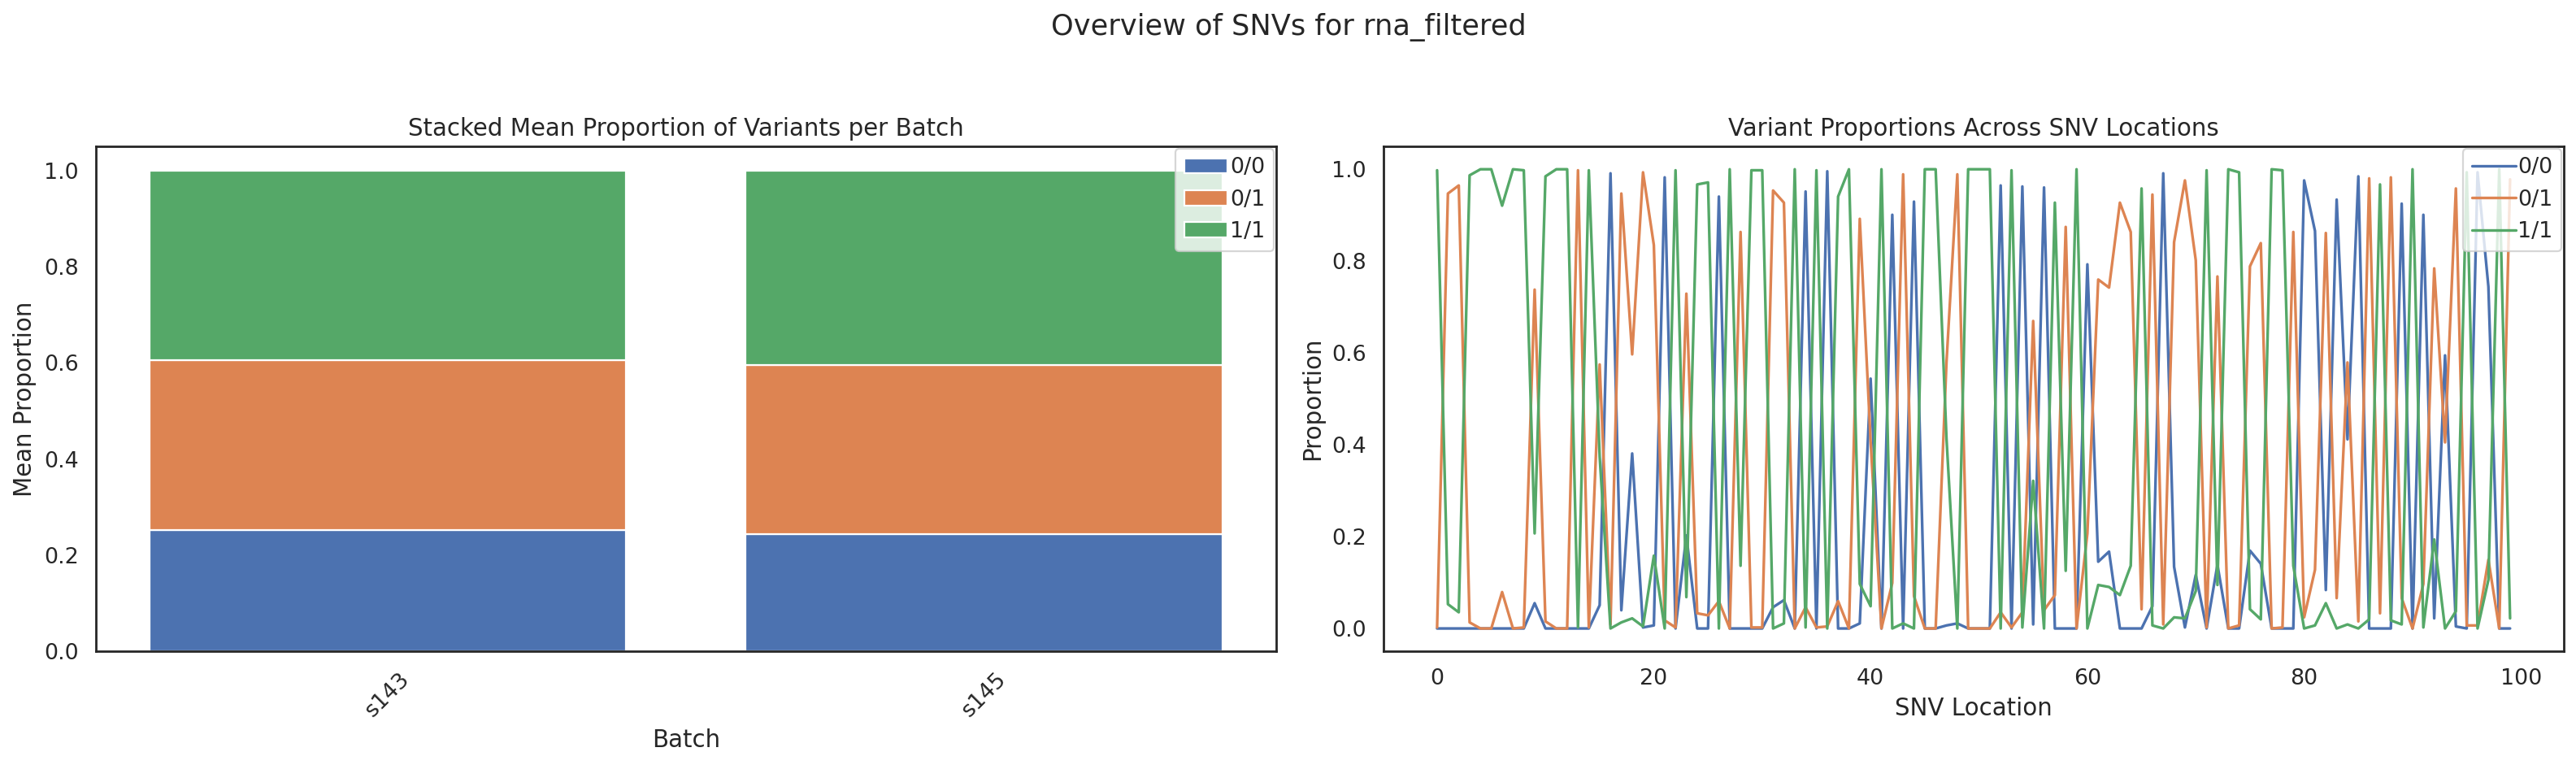

/home/jorrit/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1760x640 with 0 Axes>

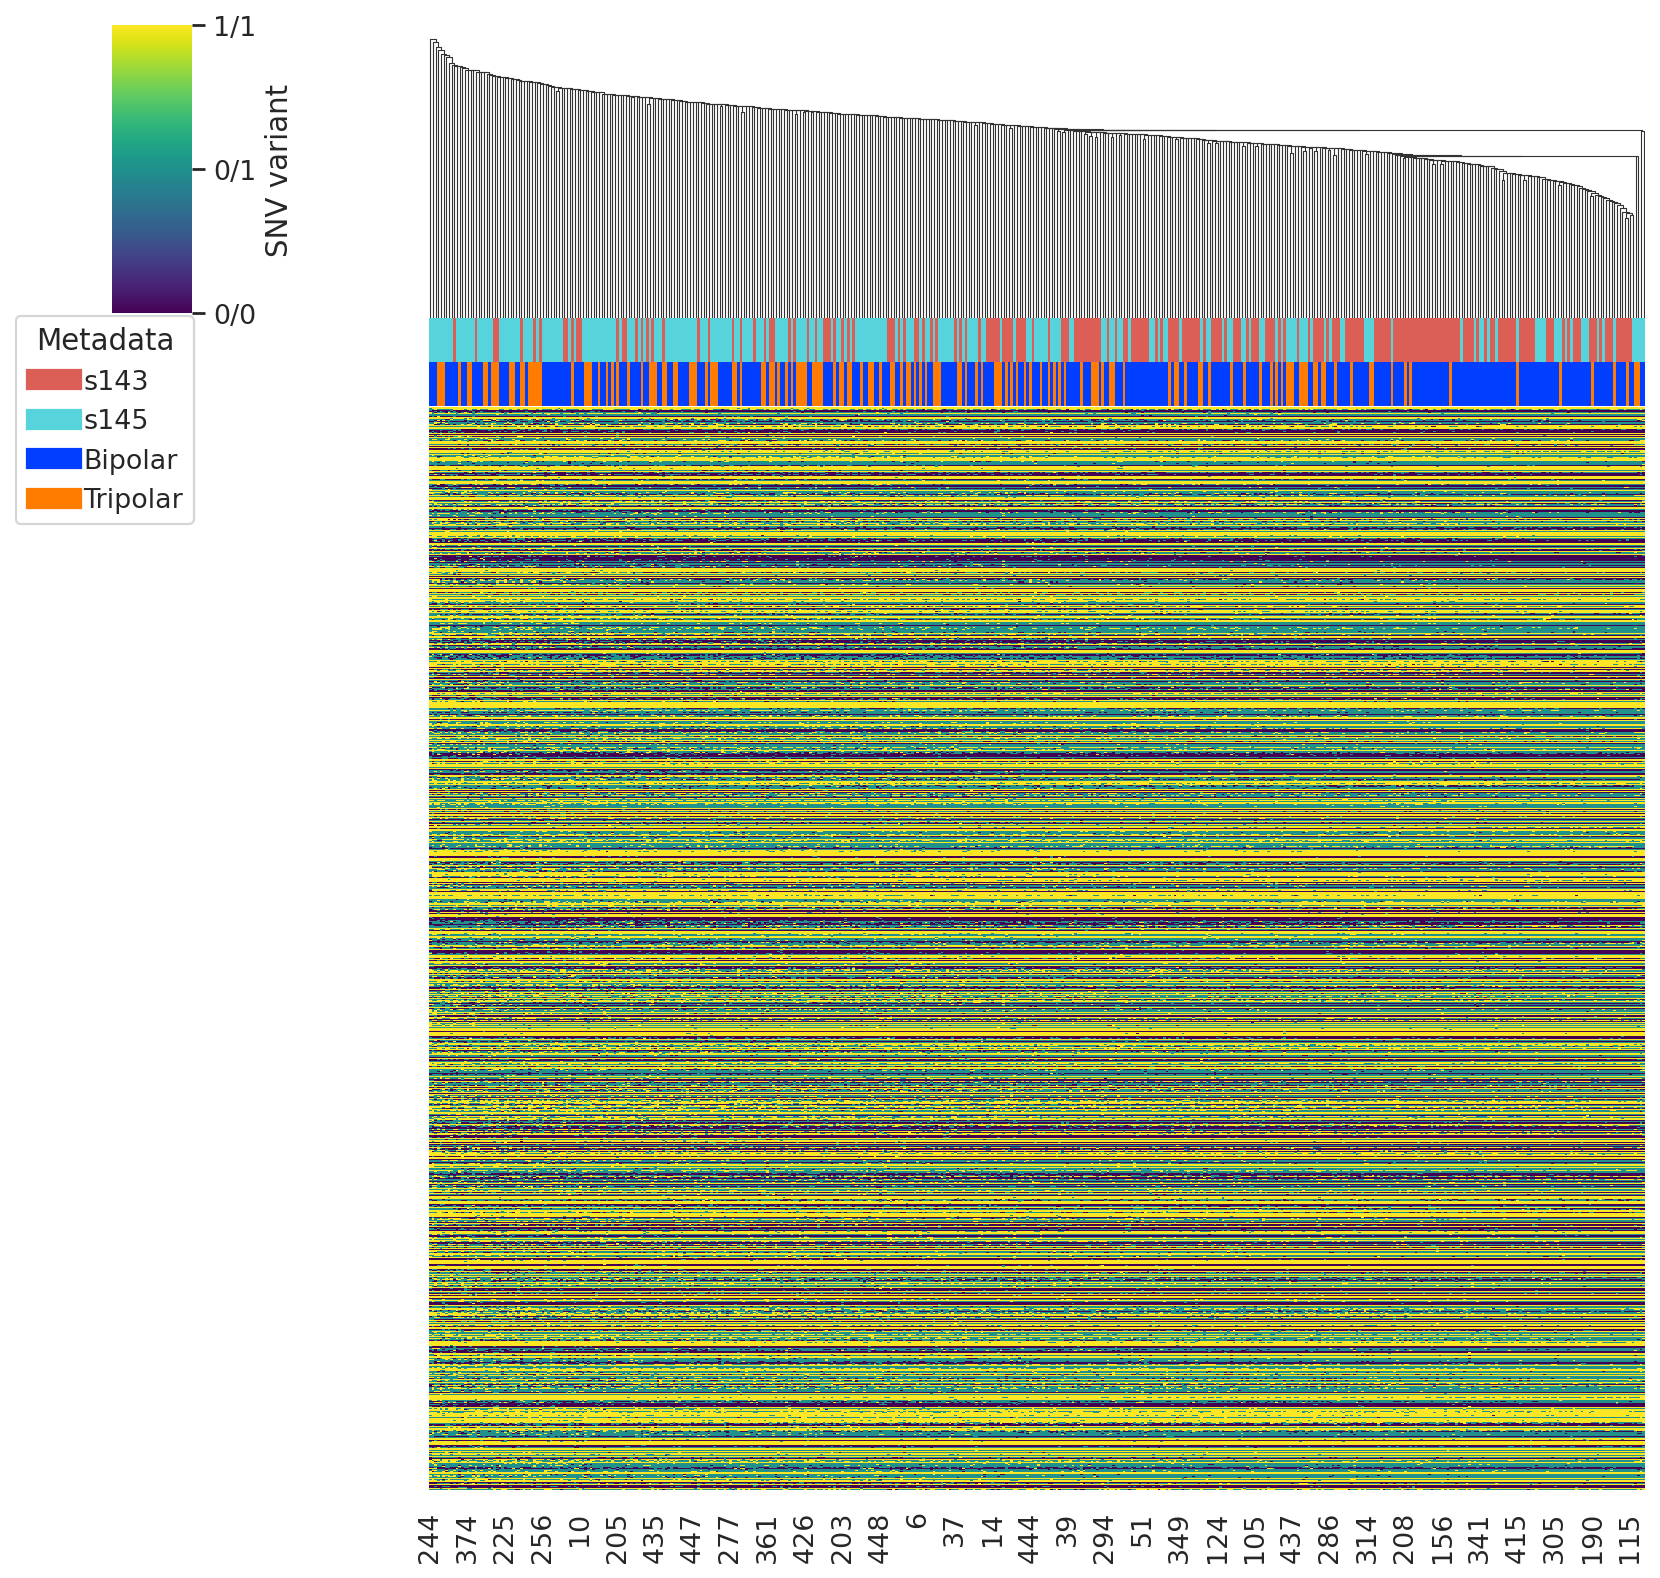

/tmp/ipykernel_523683/2075392598.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data = current_data.obs.groupby('Batch')[variants].mean()


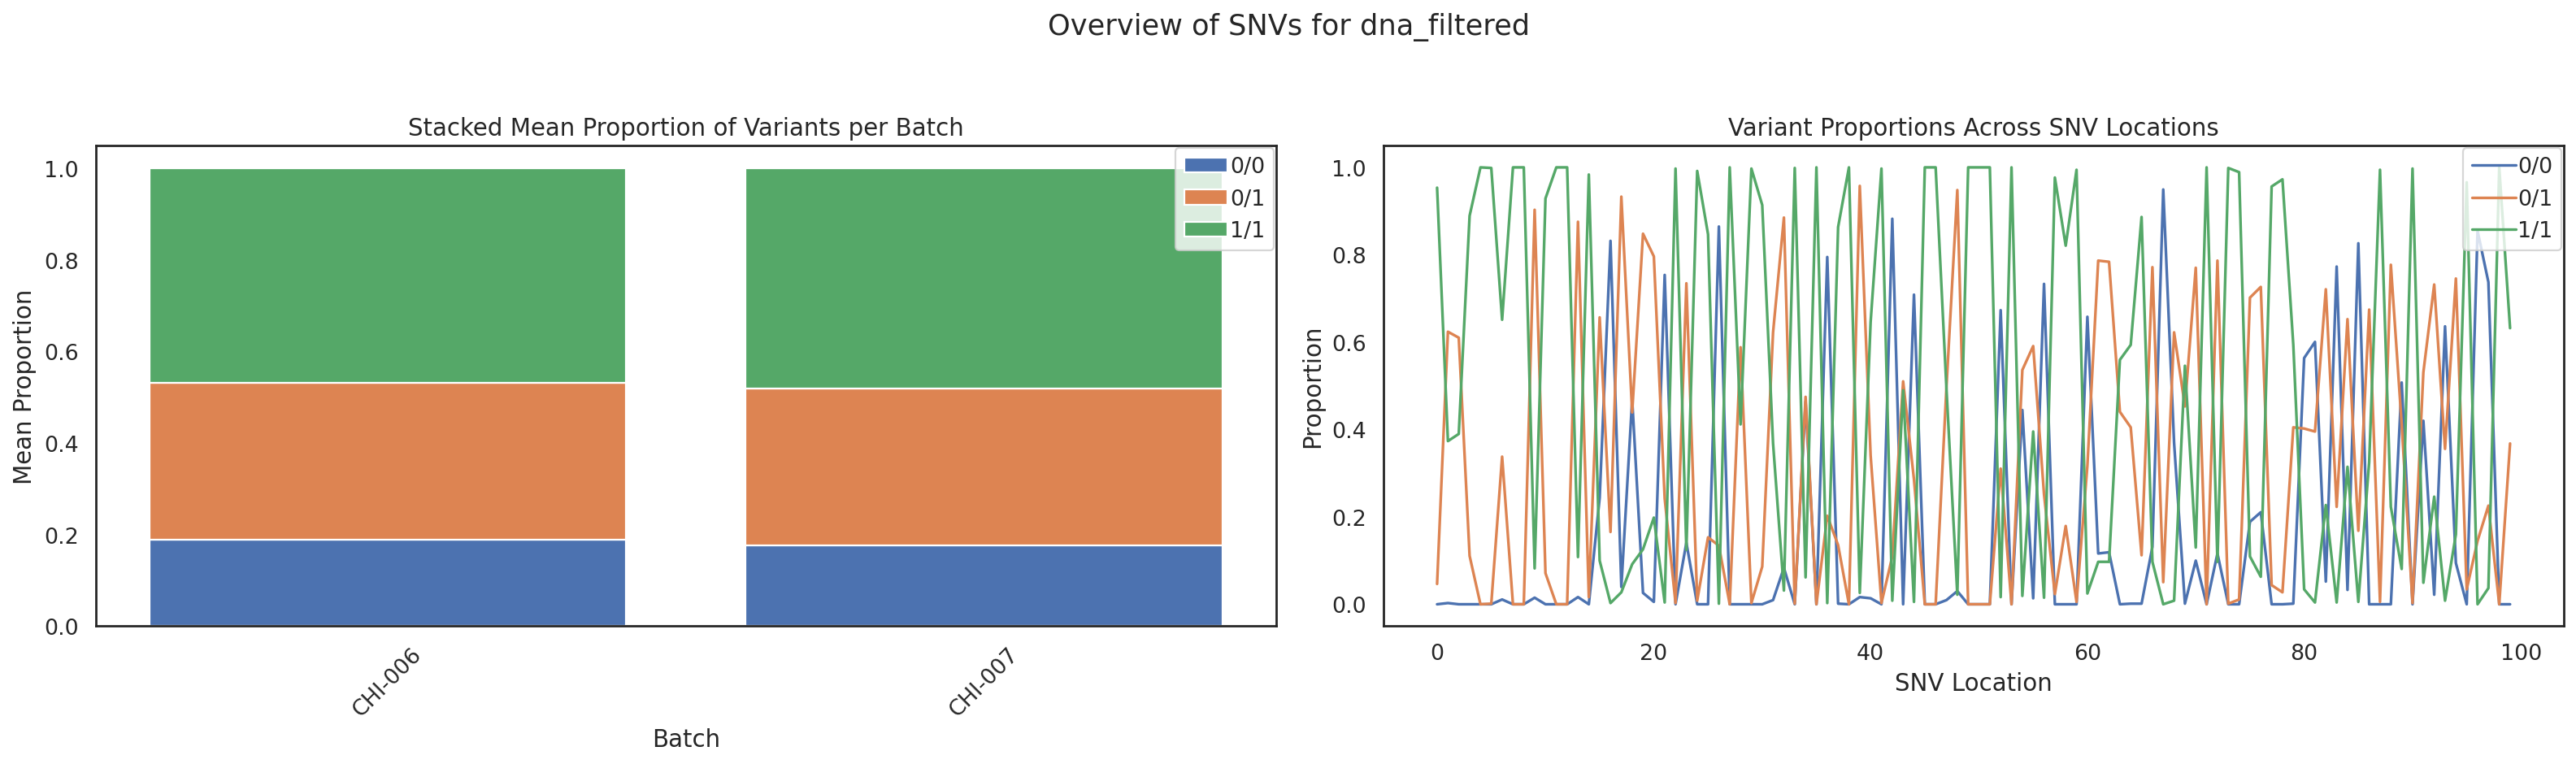

/home/jorrit/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1760x640 with 0 Axes>

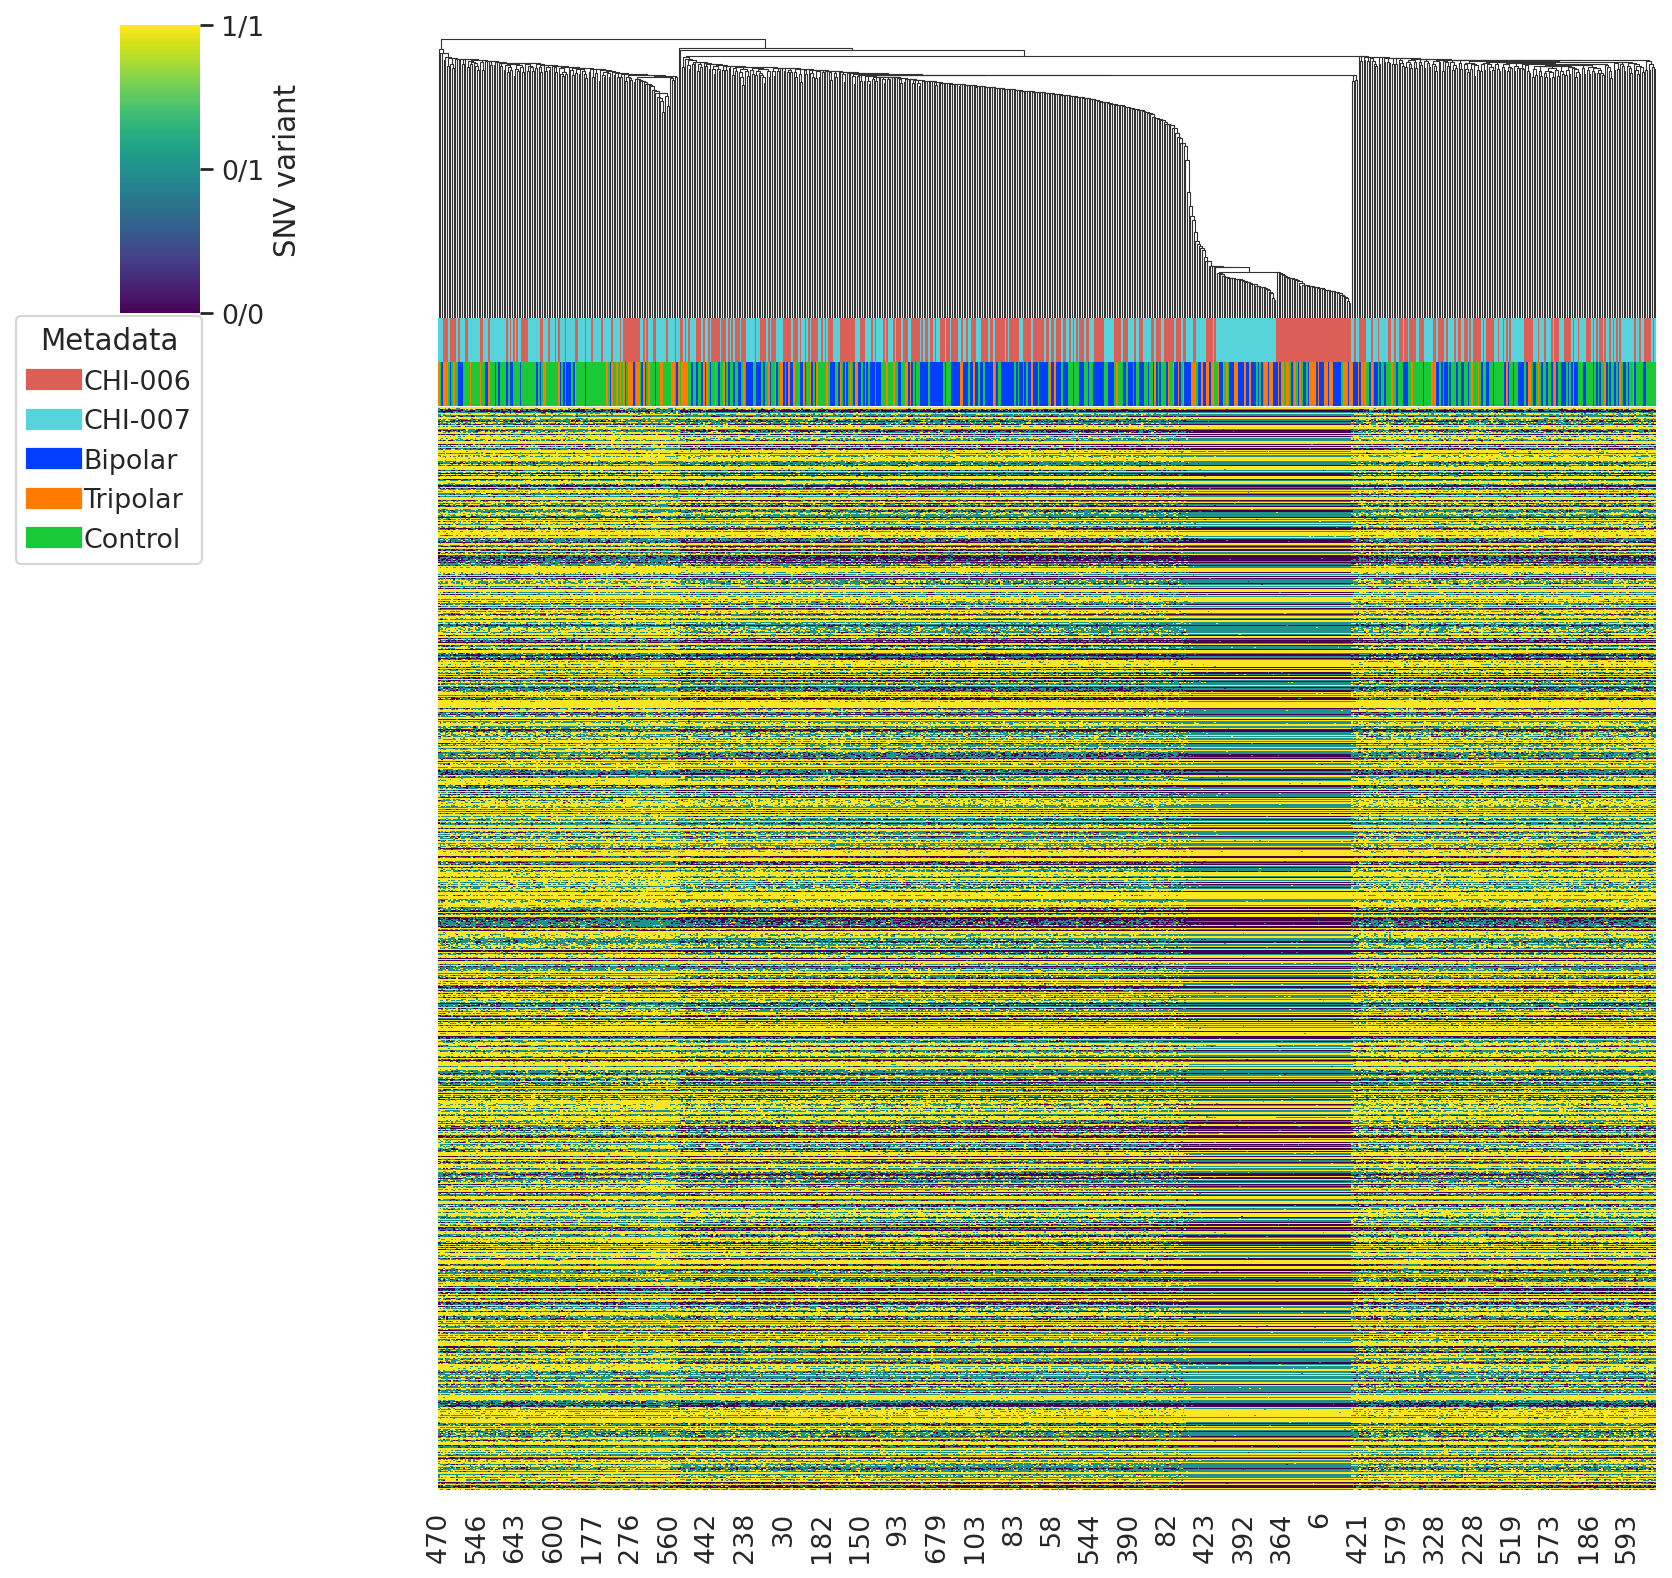

In [230]:
for key in filtered_datasets:
    current_data = data[key]
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'Overview of SNVs for {key}')
    
    axes[0] = stacked_barplot_variants(current_data, axes[0])    
    axes[1] = variant_linegraph(current_data, axes[1])

    # Show the plot for the current dataset
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

    heatmap(data[key])

## Heatmap for the combined dataset

In [167]:
adata = merge_datasets(data['rna_filtered'], data['dna_filtered'])
print(adata)

Number of intersecting SNVs: 5933
AnnData object with n_obs × n_vars = 1185 × 5933
    obs: 'Phenotype', 'Batch', 'variant_1_proportion', 'variant_2_proportion', 'variant_3_proportion', 'variant_1_proportion_0/0', 'variant_2_proportion_0/1', 'variant_3_proportion_1/1'
    var: 'AF', 'AR2', 'DR2', 'ref_allele', 'alt_allele', 'chrom', 'pos', 'pass', 'variant_1_proportion', 'variant_2_proportion', 'variant_3_proportion', 'variant_1_proportion_0/0', 'variant_2_proportion_0/1', 'variant_3_proportion_1/1'


/tmp/ipykernel_523683/2075392598.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data = current_data.obs.groupby('Batch')[variants].mean()


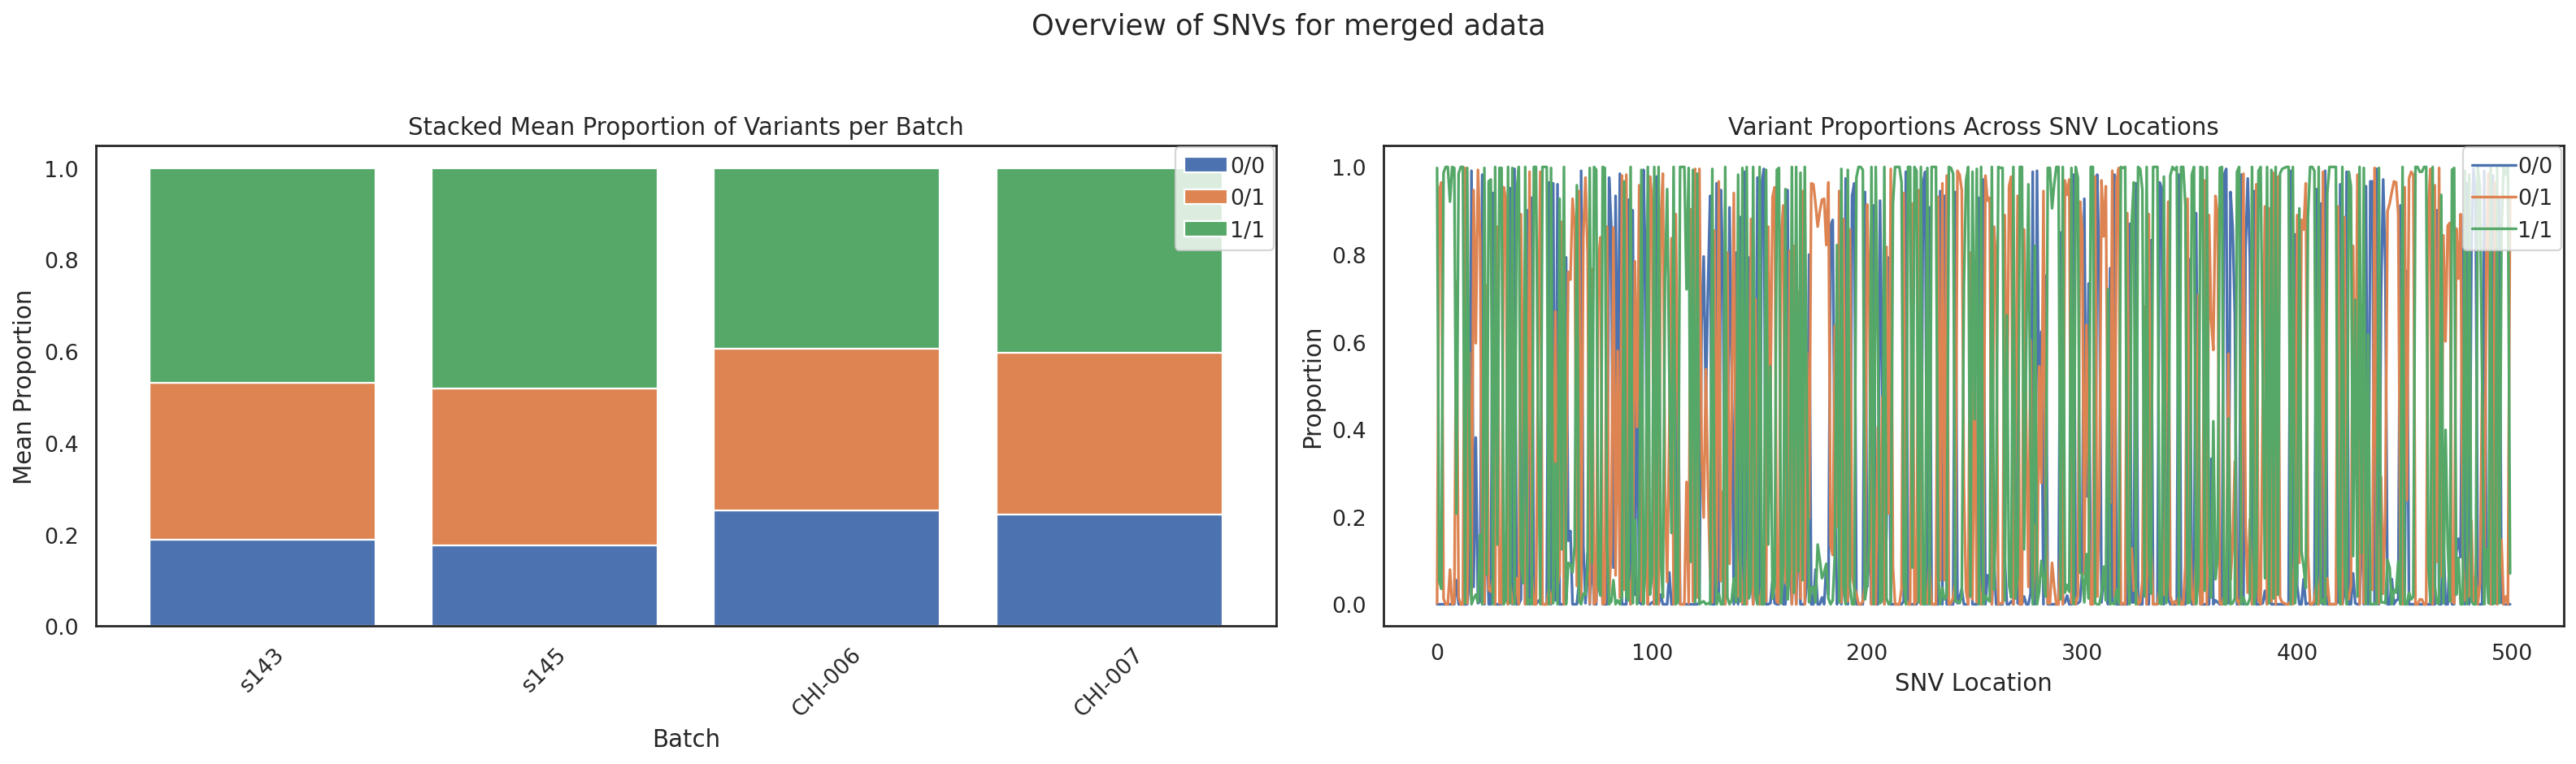

/home/jorrit/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1760x640 with 0 Axes>

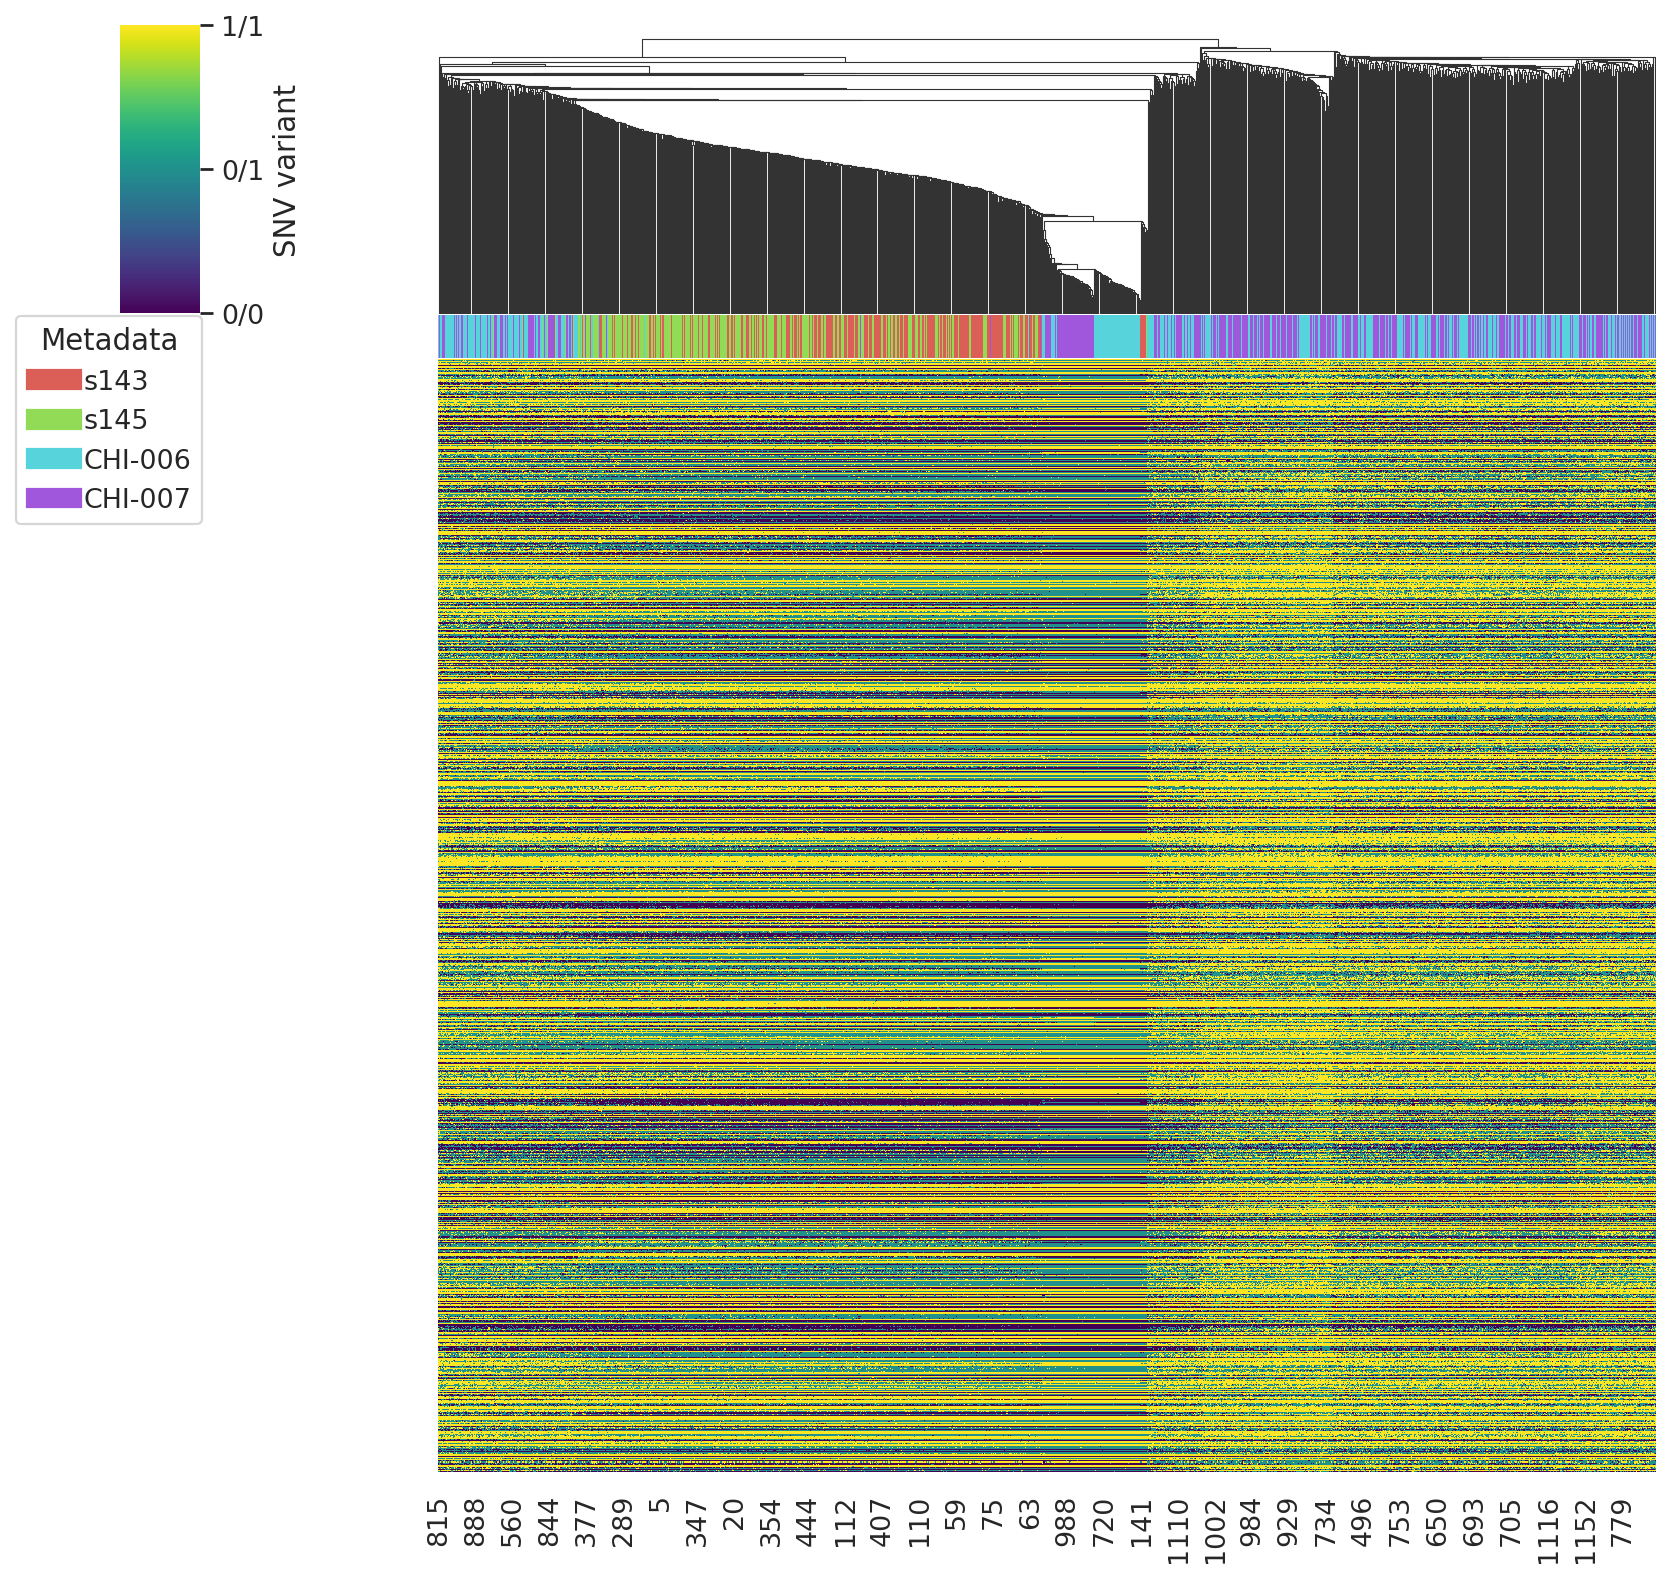

In [231]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle(f'Overview of SNVs for merged adata')
    
axes[0] = stacked_barplot_variants(adata, axes[0])    
axes[1] = variant_linegraph(adata, axes[1], 500)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

heatmap(adata, phenotype=False)